In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import GPy

In [2]:
def forrester(X):
    y = np.multiply(np.power(6*X-2,2), np.sin(2*(6*X-2)))
    return y

## Initialise data

In [3]:
def initData():
    X_train = np.array([0, 0.18, 0.25, 0.28, 0.5, 0.95, 1])
    #X_train = np.array([0.2,0.5])
    y_train = forrester(X_train)
    X_train = X_train.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    
    n_test = 200
    X_test = np.linspace(0, 1, n_test)
    y_test = forrester(X_test)
    X_test = X_test.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = initData()

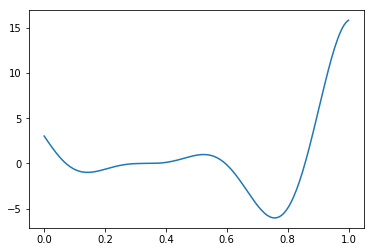

In [5]:
plt.plot(X_test,y_test)
plt.show()

## Initialise GP regression model

In [6]:
def initRegressionModel(X_train,y_train,k):
    m = GPy.models.GPRegression(X_train,y_train,k,noise_var=np.exp(-4))
    m.optimize(max_iters = 1000)
    return m

In [7]:
k = GPy.kern.RBF(1,variance=np.exp(0), lengthscale=1) 
m = initRegressionModel(X_train,y_train,k)

In [8]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,67.88031485196433,+ve,
rbf.lengthscale,0.1708155307861704,+ve,
Gaussian_noise.variance,1.7227494416075584e-06,+ve,


## Declare helper functions

In [9]:
def addConfidenceBounds(ax, x, mu, s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def removeConfidenceBounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

In [10]:
def addTrainingPoint(X_train, y_train, x_new, y_new):    
    X_train = np.append(X_train,x_new)
    y_train = np.append(y_train,y_new)
    return X_train.reshape(-1,1), y_train.reshape(-1,1)

## Bayesian optimisation routine

In [11]:
def computeEI(m, y_min, x):
    '''
    Returns the expected improvement at points x
    '''
    x = x.reshape(-1,1)
    y_mu, y_s2 = m.predict(x)
    y_s = np.sqrt(y_s2)
    pd = norm(0,1)
    z = (y_min-y_mu) / y_s
    return np.multiply((y_min-y_mu),pd.cdf(z)) + np.multiply(y_s,pd.pdf(z))

def getNegAcqFn(m, current_optimum):
    '''
    Returns the function handle for the negative acquisition function
    '''
    return lambda x: -1 * computeEI(m, current_optimum, x)

def getUpdate1D(f, X_test):
    '''
    Computes the acquisition function at all points on X_test
    Returns the acq fn and the x_value at the maximum
    '''
    negativeAcq = f(X_test)
    acq = -1*negativeAcq
    max_index = np.argmax(acq)
    x_new = X_test[max_index]
    return acq, x_new

In [12]:
# Code to create animation
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

# Initialise data and GP
X_train, y_train, X_test, y_test = initData()
k = GPy.kern.RBF(1,variance=np.exp(0), lengthscale=1) 
m = initRegressionModel(X_train,y_train,k)
mu_test, s2_test = m.predict(X_test)
s_test = np.sqrt(s2_test) 

# Get current optimum
current_optimum = min(y_train)

# Construct acquisition function
f = getNegAcqFn(m, current_optimum)

# Obtain next infill point 
acq, x_new = getUpdate1D(f, X_test)

# Initialise plot
fig,(ax0,ax1) = plt.subplots(2,1, figsize=(8, 6), gridspec_kw = {'height_ratios':[3, 1]}, dpi=100)

ax0.set_xlim(0,1)
ax0.set_ylim(-10,20)
ax0.set_title('Bayes demo')
ax1.set_title('Acquisition function')
plt.ylabel('y'); plt.xlabel('x');

line_post, = ax0.plot(X_test, mu_test, label="pred_fn")
line_true, = ax0.plot(X_test, y_test, label="true_fn")
line_next1 = ax0.axvline(x_new, color='r', linestyle="dashed")
pts_train, = ax0.plot(X_train, y_train,'rx', label="training points")
addConfidenceBounds(ax0, X_test, mu_test, s_test)
ax0.legend(handles=[line_post, line_true, pts_train],loc="upper right")

line_acq, = ax1.plot(X_test, acq, label="acq_fn")
line_next2 = ax1.axvline(x_new, color='r', linestyle="dashed")
ax1.legend()
plt.tight_layout()

def addAndRetrain(b=None):
    global X_train, y_train, mu_test, s_test, acq, x_new, current_optimum, m
    # Sample at infill point
    y_new = forrester(x_new)
    
    # Update current optimum
    if y_new < current_optimum:
        current_optimum = y_new
    
    # Update training data and retrain
    X_train,y_train = addTrainingPoint(X_train,y_train,x_new,y_new) 
    m.set_XY(X_train,y_train)
    m.optimize(max_iters = 100)
    
    # Re-generate predictions
    mu_test, s2_test = m.predict(X_test)
    s_test = np.sqrt(s2_test)
    
    # Construct acquisition function
    f = getNegAcqFn(m, current_optimum)

    # Obtain next infill point 
    acq, x_new = getUpdate1D(f, X_test)
    
    updatePlot()

def updatePlot():
    line_post.set_data(X_test,mu_test)
    line_acq.set_data(X_test,acq)
    pts_train.set_data(X_train,y_train)
    line_next1.set_xdata(x_new)
    removeConfidenceBounds(ax0)
    addConfidenceBounds(ax0, X_test, mu_test, s_test)    
    
    line_next2.set_xdata(x_new)
    ax1.relim()
    ax1.autoscale_view()
    fig.canvas.draw()
    
def animate(i):
    if i == 0: pass
    else: addAndRetrain()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=4, interval = 2000)

In [13]:
ani